## K-means 

In [2]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [9]:
coordination_source = """
{name:'兰州', geoCoord:[103.73, 36.03]},
{name:'嘉峪关', geoCoord:[98.17, 39.47]},
{name:'西宁', geoCoord:[101.74, 36.56]},
{name:'成都', geoCoord:[104.06, 30.67]},
{name:'石家庄', geoCoord:[114.48, 38.03]},
{name:'拉萨', geoCoord:[102.73, 25.04]},
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

## Feacutre Extractor 

In [3]:
city_location = {
    '香港': (114.17, 22.28)
}

In [4]:
test_string = "{name:'兰州', geoCoord:[103.73, 36.03]},"

In [5]:
import re

In [6]:
pattern = re.compile(r"name:'(\w+)',\s+geoCoord:\[(\d+.\d+),\s(\d+.\d+)\]")

In [10]:
for line in coordination_source.split('\n'):
    city_info = pattern.findall(line)
    if not city_info: continue
    
    # following: we find the city info
    
    city, long, lat = city_info[0]
    
    long, lat = float(long), float(lat)
    
    city_location[city] = (long, lat)

In [14]:
city_location

{'香港': (114.17, 22.28)}

In [13]:
import math

In [14]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

## Vector Distances

+ 余弦距离 Cosine Distance

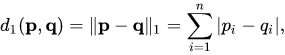
+ 欧几里得距离 Euclidean Distance

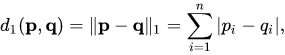

+ 曼哈顿距离 Manhattan distance or Manhattan length

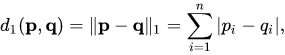

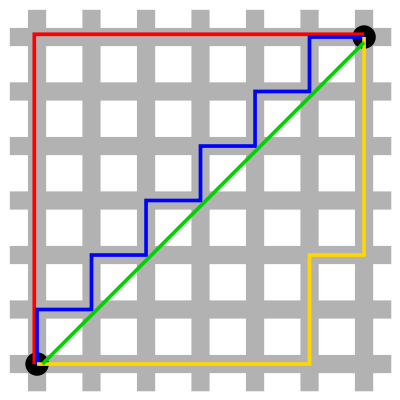

In [15]:
import matplotlib.pyplot as plt

In [16]:
import networkx as nx

In [17]:
%matplotlib inline

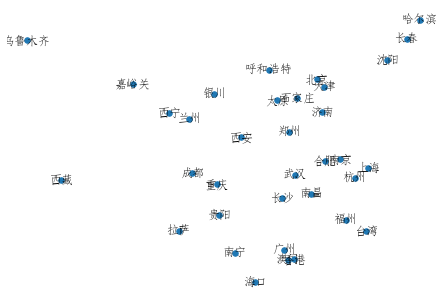

In [18]:
city_graph = nx.Graph()
city_graph.add_nodes_from(list(city_location.keys()))
nx.draw(city_graph, city_location, with_labels=True, node_size=30)

## K-means: Initial k random centers

In [19]:
k = 10

In [20]:
import random

In [21]:
all_x = []
all_y = []

for _, location in city_location.items():
    x, y = location
    
    all_x.append(x)
    all_y.append(y)

In [22]:
def get_random_center(all_x, all_y):
    r_x = random.uniform(min(all_x), max(all_x))
    r_y = random.uniform(min(all_y), max(all_y))
    
    return r_x, r_y

In [23]:
get_random_center(all_x, all_y)

(92.38732121863369, 42.25252433033021)

In [24]:
K = 5
centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}

In [25]:
from collections import defaultdict

In [26]:
closet_points = defaultdict(list)

for x, y, in zip(all_x, all_y):
    closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])    
    
    closet_points[closet_c].append([x, y])

In [27]:
import numpy as np

In [28]:
def iterate_once(centers, closet_points, threshold=5):
    have_changed = False
    
    for c in closet_points:
        former_center = centers[c]

        neighbors = closet_points[c]

        neighbors_center = np.mean(neighbors, axis=0)

        if geo_distance(neighbors_center, former_center) > threshold:
            centers[c] = neighbors_center
            have_changed = True
        else:
            pass ## keep former center
        
    return centers, have_changed

In [29]:
def kmeans(Xs, k, threshold=5):
    all_x = Xs[:, 0]
    all_y = Xs[:, 1]
    
    K = k
    
    centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}
    
    changed = True
    
    while changed:
        closet_points = defaultdict(list)

        for x, y, in zip(all_x, all_y):
            closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])    
            closet_points[closet_c].append([x, y])   
            
        centers, changed = iterate_once(centers, closet_points, threshold)
        print('iteration')

    return centers

In [30]:
kmeans(np.array(list(city_location.values())), k=5, threshold=5)

iteration
iteration
iteration
iteration
iteration
iteration


{'1': array([108.85111111,  24.70666667]),
 '2': array([117.02545455,  39.35272727]),
 '3': array([99.518, 38.86 ]),
 '4': array([117.94666667,  29.32222222]),
 '5': array([91.11, 29.97])}

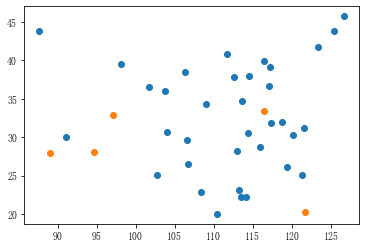

In [31]:
plt.scatter(all_x, all_y)
plt.scatter(*zip(*centers.values()))

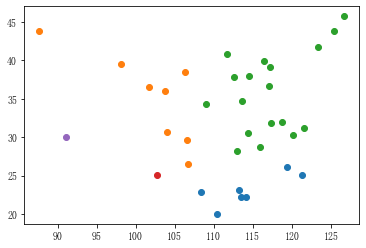

In [32]:
for c, points in closet_points.items():
    plt.scatter(*zip(*points))

In [33]:
city_location_with_station = {
    '能源站-{}'.format(i): position for i, position in centers.items()
}

In [34]:
city_location_with_station

{'能源站-1': (89.07313701685077, 27.977397760497425),
 '能源站-2': (94.65049012096662, 28.131481809844367),
 '能源站-3': (116.46721577590225, 33.46575924894795),
 '能源站-4': (97.09669948980351, 32.87874209912005),
 '能源站-5': (121.6054574108192, 20.320013020288773)}

In [35]:
def draw_cities(citise, color=None):
    city_graph = nx.Graph()
    city_graph.add_nodes_from(list(citise.keys()))
    nx.draw(city_graph, citise, node_color=color, with_labels=True, node_size=30)

In [36]:
%matplotlib inline

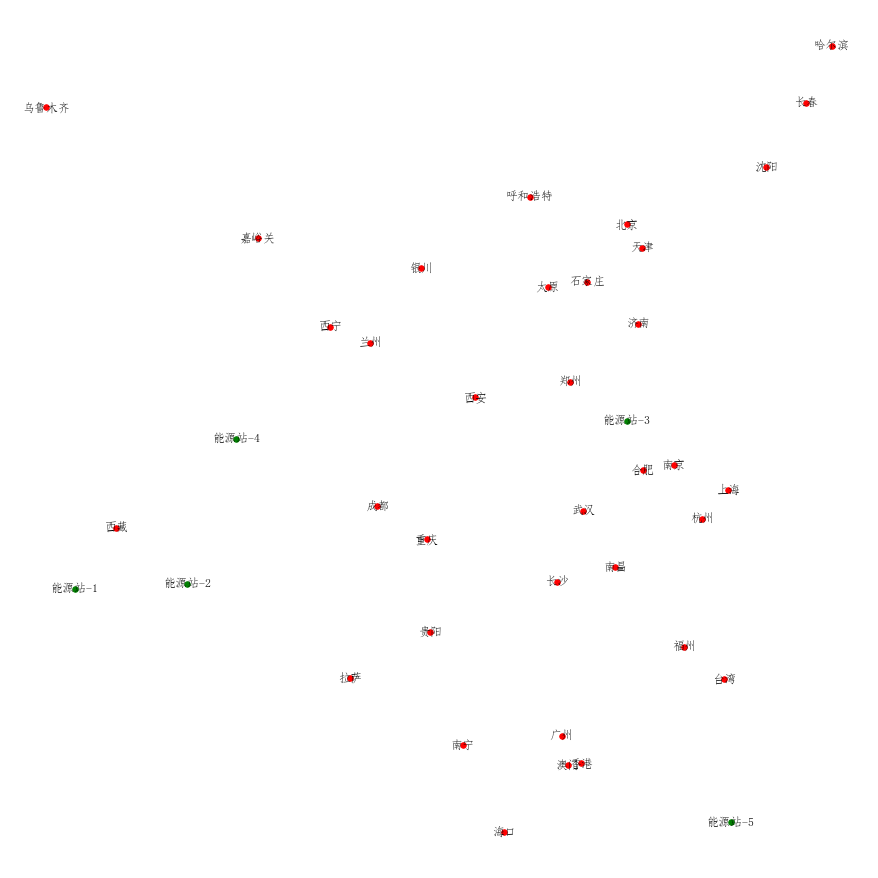

In [37]:
plt.figure(1,figsize=(12,12)) 
draw_cities(city_location_with_station, color='green')
draw_cities(city_location, color='red')